In [93]:
import os
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
os.chdir(os.path.split(workbookDir)[0])

In [94]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Synthetic data generation

In [95]:
import warnings
warnings.filterwarnings(action='ignore', message="numpy.dtype size changed")

In [96]:
import pandas as pd

In [97]:
# choice: 'basic', 'id'
synthesizer = 'basic'

## Load transactions

In [98]:
data = pd.read_csv('data/transactions.csv')
data.head(10)

,Unnamed: 0,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,mean_income
0,0,695247,2378,1993-01-01,1,2.0,700.0,700.0,NaN,NaN,NaN,[ 11271.53754941]
1,1,695250,2378,1993-01-22,1,2.0,7268.0,7968.0,NaN,NaN,NaN,[ 11271.53754941]
2,2,695266,2378,1993-01-23,1,2.0,14440.0,22408.0,NaN,NaN,NaN,[ 11271.53754941]
3,3,695262,2378,1993-01-24,1,2.0,49752.0,72160.0,NaN,NaN,NaN,[ 11271.53754941]
4,4,695265,2378,1993-01-26,1,2.0,21899.0,94059.0,NaN,NaN,NaN,[ 11271.53754941]
5,5,695560,2378,1993-01-31,0,3.0,34700.0,59453.7,NaN,NaN,NaN,[ 11271.53754941]
6,6,3608592,2378,1993-01-31,1,NaN,94.7,94153.7,2,NaN,NaN,[ 11271.53754941]
7,7,695272,2378,1993-02-05,1,2.0,30192.0,89645.7,NaN,NaN,NaN,[ 11271.53754941]
8,8,695340,2378,1993-02-07,0,0.0,9612.0,80033.7,4,EF,1222903.0,[ 11271.53754941]
9,9,695270,2378,1993-02-11,1,2.0,31038.0,111071.7,NaN,NaN,NaN,[ 11271.53754941]


## Clean dataset

* Leave target columns only (so far: type, operation, amount)
* Filter NaN values
* Convert columns to appropriate type

In [99]:
if synthesizer == 'id':
    data = data[['account_id', 'type', 'operation', 'amount']]
else:
    data = data[['type', 'operation', 'amount']]
data = data.dropna()
data = data[data['type'] != 'VYBER']
if synthesizer == 'id':
    data['account_id'] = data['account_id'].astype(dtype='int32')
    id_normalization = {x: n for n, x in enumerate(data['account_id'].unique())}
    data['account_id'] = data['account_id'].map(arg=id_normalization)
data['type'] = data['type'].astype(dtype='int')
data['type'] = data['type'].astype(dtype='category')
data['operation'] = data['operation'].astype(dtype='int')
data['operation'] = data['operation'].astype(dtype='category')
data['amount'] = data['amount'].astype(dtype='float32')
data.head(10)

,type,operation,amount
0,1,2,700.0
1,1,2,7268.0
2,1,2,14440.0
3,1,2,49752.0
4,1,2,21899.0
5,0,3,34700.0
7,1,2,30192.0
8,0,0,9612.0
9,1,2,31038.0
10,0,3,25200.0


In [100]:
from sklearn.model_selection import train_test_split

In [101]:
data, test = train_test_split(data, test_size=0.2, random_state=42)

## Train model and synthesized data

In [102]:
if synthesizer == 'id':
    from synthesized.core import IdSynthesizer
    synthesizer = IdSynthesizer
elif synthesizer == 'basic':
    from synthesized.core import BasicSynthesizer
    synthesizer = BasicSynthesizer

In [103]:
with synthesizer(dtypes=data.dtypes) as synthesizer:
    synthesizer.learn(data=data, verbose=5000)
    synthesized = synthesizer.synthesize(n=10000)

5000: 1.79e+08
10000: 1.37e+08
15000: 1.52e+08
20000: 1.33e+08
25000: 6.96e+07
30000: 4.77e+06
35000: 8.31e+05
40000: 1.62e+07
45000: 4.40e+06
50000: 3.00e+05


## Display synthesized data

In [104]:
synthesized.head(10)

,amount,operation,type
0,2828.489502,3,0
1,5285.984863,3,0
2,6386.333496,3,0
3,3691.352539,3,0
4,7005.660156,3,0
5,20719.222656,2,0
6,15.096391,3,0
7,22744.703125,2,1
8,15087.965820,3,0
9,21.271679,3,0


# Visualization of original and synthetic data

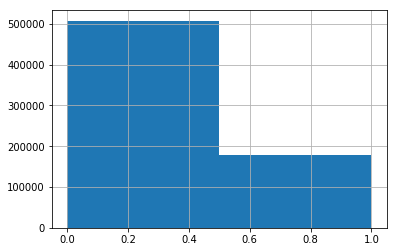

In [105]:
data['type'].hist(bins=2, range=[0, 1])

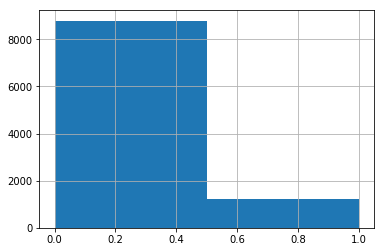

In [106]:
synthesized['type'].hist(bins=2, range=[0, 1])

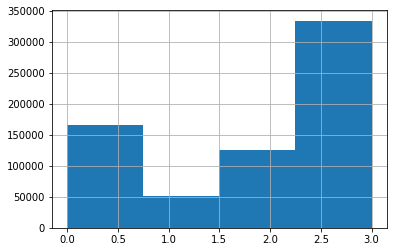

In [107]:
data['operation'].hist(bins=4, range=[0, 3])

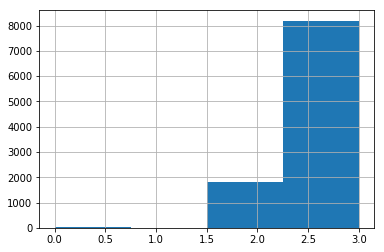

In [108]:
synthesized['operation'].hist(bins=4, range=[0, 3])

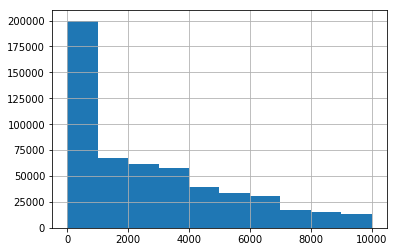

In [109]:
data['amount'].hist(bins=10, range=[0.0, 10000.0])

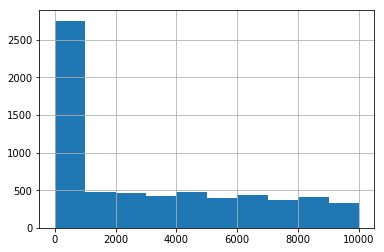

In [110]:
synthesized['amount'].hist(bins=10, range=[0.0, 10000.0])

# Tests to confirm the utility of synthetic data 

In [111]:
from synthesized.testing.testing_environment import Testing, ColumnType
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [112]:
synthesized.head(5)

,amount,operation,type
0,2828.489502,3,0
1,5285.984863,3,0
2,6386.333496,3,0
3,3691.352539,3,0
4,7005.660156,3,0


In [113]:
testing = Testing(data, test, synthesized, schema={
    'type': ColumnType.CATEGORICAL,
    'operation': ColumnType.CATEGORICAL,
    'amount': ColumnType.CONTINUOUS,
})

In [114]:
testing.estimate_utility(classifier=DecisionTreeClassifier(), regressor=DecisionTreeRegressor())

,target_column,estimator,dummy_original_score,original_score,synth_score,orig_error,synth_error,score_utility,error_utility
0,amount,DecisionTreeRegressor,0.000000,0.199508,0.000000,9000.333861,10271.248957,0.000000,0.876265
1,amount (categorical reduction),DecisionTreeClassifier,0.757379,0.757379,0.683850,0.242621,0.316150,NaN,0.767426
2,operation,DecisionTreeClassifier,0.489277,0.976423,0.622283,0.023577,0.377717,0.273031,0.062421
3,type,DecisionTreeClassifier,0.741921,1.000000,0.831747,0.000000,0.168253,0.348058,0.000000


In [115]:
testing.compare_marginal_distributions(target_column='operation', conditional_column='amount')

,amount,operation EMD
0,"[0.0, 21825.0)",0.379635
1,"[21825.0, 43650.0)",0.424595
2,"[43650.0, 65475.0)",0.580544
3,"[65475.0, 87300.0)",inf


In [116]:
testing.compare_marginal_distributions(target_column='type', conditional_column='amount', bins=10)

,amount,type EMD
0,"[0.0, 8730.0)",0.159716
1,"[8730.0, 17460.0)",0.367509
2,"[17460.0, 26190.0)",0.056855
3,"[26190.0, 34920.0)",0.333286
4,"[34920.0, 43650.0)",0.243694
5,"[43650.0, 52380.0)",0.192293
6,"[52380.0, 61110.0)",0.778721
7,"[61110.0, 69840.0)",inf
8,"[69840.0, 78570.0)",inf
9,"[78570.0, 87300.0)",inf


# Tests to confirm the security of original data 

In [117]:
from synthesized.testing.linkage_attack import identify_attacks, Column, show_attacked_data, eradicate_attacks

## Focus on a small chunk of original data for demo purposes

In [118]:
data_orig_reduced = data.head(30000)

## Define schema for security checks

Each attribute in a dataset has the following properties to be specified by the user
1. "key_attribute" - whether the attribute can be available to the attacker as background knowledge 
2. "sensitive" - whether the attribute is SPI 
3. "categorical" - wtether the attribute is a categorical variable

In [119]:
schema = {
    'type': Column(key_attribute=False, sensitive=True, categorical=True),
    'operation': Column(key_attribute=True, sensitive=True, categorical=True),
    'amount': Column(key_attribute=True, sensitive=True, categorical=False),
}

## Identify and demonstrate vulnerabilities in synthetic data

In [ ]:
attacks = identify_attacks(data_orig_reduced, synthesized, schema)

In [ ]:
len(attacks)

In [ ]:
show_attacked_data(data_orig_reduced, synthesized, attacks[100], schema)

## Clear the synthetic dataset from vulnerabilities

In [ ]:
cleared_df = eradicate_attacks(data_orig_reduced, synthesized, attacks, schema)

## Demonstrate the security of synthetic data

In [ ]:
new_attacks = identify_attacks(data_orig_reduced, cleared_df, schema)

In [ ]:
len(new_attacks)

## Demonstrate the utility of synthetic data cleared from all vulnerabilities

In [ ]:
testing = Testing(data, cleared_df, synthesized, schema={
    'type': ColumnType.CATEGORICAL,
    'operation': ColumnType.CATEGORICAL,
    'amount': ColumnType.CONTINUOUS,
})

In [ ]:
testing.estimate_utility(classifier=DecisionTreeClassifier(), regressor=DecisionTreeRegressor())

## Demonstrate the synthetic dataset to be released to the user

In [ ]:
synthesized